# Animal Shelter dataset analysis
-----------------------------------------------------------------------------------------


## Introduction
- This notebook will apply the cleaned dataset from original animal shelter analysis and use it to build and evaluate prediction models that capture the relationship between the descriptive features and the target feature binary outcome. 
    - The value “negative” or "1" indicates that the outcome of the animal was negative form the animal shelter for example death. 
    - The value “positive” or "0" indicates that the outcome of the animal form the shelter was positive eg was adopted from the shelter or returned to owner.
- Each model will be a supervised learning model and the output will be a binary classification. 
- For each animal a number of features will be given (independent variables) and the target, bianry outcome (dependent variable), will be predicted.

This will be broken down into 4 main parts:
1. We will review the dataset from original animal shelter analysis and decide on which features to use to build our model
2. We will create a Linear Regression model and analyse
3. We will create a Logistical Regression model and analyse
4. We will create a Random Forest model and analyse
5. We will then try to optimize each model  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source
from graphviz import Graph
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# (1) Data understanding and prep:

The original dataset has been cleaned (Homework 1) and is now imported as a starting point for this homework. 
1. The accompanying data quality report from homework 1 can be found attached as PDF as a background to this cleaned dataset;
2. A summary of this plan can be seen in the table below;
3. In addition a number of extra features were added (to to better capture the problem domain) that were not in the original dataset.
    - Age Intake : The age of animal coming into the shelter
    - Age outcome : The age of animal leaving the shelter
    - Duration of stay (in days): Measure the length of stay of each animal in the shelter


### Summary of data quality plan:

| Variable Names                     | Data Quality Issue            | Handling Strategy              |
|------------------------------------|-------------------------------|--------------------------------|
| Animal ID                          | Scale                         | Drop Feature                  |
| Name_Intake                        | Scale, missing values         | Drop Feature                     |
| DateTime_Intake                    | Invalid cardinality           | Replace with duration, Drop Rows|
| MonthYear_Intake                   | Duplicate                     | Drop Feature                   |
| Found Location                     | Scale                         | Do nothing                  |
| Intake Type                        | Undefined value               | Do nothing                    |
| Intake Condition                   | Undefined value               | Do nothing                |
| Animal Type_Intake                 | Outliers                      | Do Nothing                     |
| Sex upon Intake                    | Scale                         | Do Nothing                     |
| Age upon Intake                    | Invalid cardinality           | Replace with age intake in days, Drop Rows|
| Breed_Intake                       | Scale                         | Reduce cardinality  |
| Color_Intake                       | Scale                         | Drop Feature  |
| Name_Outcome                       | Duplicate                     | Drop Feature                   |
| DateTime_Outcome                   | Invalid cardinality           | Replace with duration, Drop Feature|
| MonthYear_Outcome                  | Duplicate                     | Drop Feature                   |
| Date of Birth                      | Outliers                      | Drop Feature                     |
| Animal Type_Outcome                | Duplicate                     | Drop Feature                   |
| Sex upon Outcome	                 | Scale                         | Do nothing                     |
| Age upon Outcome                   | Invalid cardinality           | Replace with age outcome in days, Drop Rows|
| Breed_Outcome                      | Duplicate                     | Drop Feature                   |
| Color_Outcome                      | Duplicate                     | Drop Feature                   |
| binary_outcome                     | Invalid cardinality           | convert to categorical type    |


##  1.1 Review, prepare and split the dataset into two datasets: 70% training and 30% test
Here we will import cleaned dataset <br>
The first thing we will do with the dataset is to preform Integrity checks to ensure the data makes sense.


In [2]:
# read in the cleaned csv
df = pd.read_csv("animalShelter_cleaned_new_features_all.csv", keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

df.head(5)

,Animal ID,Found Location,Intake Type,Intake Condition,Animal Type_Intake,Sex upon Intake,Breed_Intake,Color_Intake,Sex upon Outcome,binary_outcome,Age Outcome,Age Intake,percent,Duration of Stay (in days),monthIntake,monthOutcome,Unnamed: 0,Animal Type_Outcome,Breed_Outcome,Color_Outcome
0,A674745,E Howard And Harris Ridge in Austin (TX),Wildlife,Injured,Other,Unknown,Skunk Mix,Black/White,Unknown,negative,365,365,2.272727,0,3,3,0,Other,Skunk Mix,Black/White
1,A797639,3608 Verano Drive in Austin (TX),Stray,Normal,Cat,Intact Female,Domestic Shorthair,Black,Intact Female,positive,82,76,0.137174,6,6,6,1,Cat,Domestic Shorthair,Black
2,A694741,Austin (TX),Owner Surrender,Normal,Cat,Spayed Female,Domestic Medium Hair Mix,Black/White,Spayed Female,positive,3673,3652,0.636943,21,1,1,2,Cat,Domestic Medium Hair Mix,Black/White
3,A749932,1413 Webberville Rd in Austin (TX),Stray,Normal,Cat,Intact Female,Domestic Shorthair Mix,Brown Tabby,Spayed Female,positive,63,22,0.137174,41,5,7,3,Cat,Domestic Shorthair Mix,Brown Tabby
4,A755577,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,Rat Terrier Mix,Black/Gray,Neutered Male,positive,2197,2192,0.636943,5,8,8,4,Dog,Rat Terrier Mix,Black/Gray


### Check logical integrity of data 

1. Test the duration of stay values are all greater than 1

In [3]:
test_1 = (df["Duration of Stay (in days)"] < 0)
df.loc[test_1 == True]


,Animal ID,Found Location,Intake Type,Intake Condition,Animal Type_Intake,Sex upon Intake,Breed_Intake,Color_Intake,Sex upon Outcome,binary_outcome,Age Outcome,Age Intake,percent,Duration of Stay (in days),monthIntake,monthOutcome,Unnamed: 0,Animal Type_Outcome,Breed_Outcome,Color_Outcome


2. Check that intake type and outcome type are the same values as it is impossible for animal types to change in an animal shelter

In [4]:
test_2 = df["Animal Type_Outcome"] == df["Animal Type_Intake"]
df.loc[test_2 == False]


,Animal ID,Found Location,Intake Type,Intake Condition,Animal Type_Intake,Sex upon Intake,Breed_Intake,Color_Intake,Sex upon Outcome,binary_outcome,Age Outcome,Age Intake,percent,Duration of Stay (in days),monthIntake,monthOutcome,Unnamed: 0,Animal Type_Outcome,Breed_Outcome,Color_Outcome


3. Check that Breed income and outcome type are the same values as it is impossible for animal breeds to change in an animal shelter

In [5]:
test_3 = df["Breed_Intake"] == df["Breed_Outcome"]
df.loc[test_3 == False]

,Animal ID,Found Location,Intake Type,Intake Condition,Animal Type_Intake,Sex upon Intake,Breed_Intake,Color_Intake,Sex upon Outcome,binary_outcome,Age Outcome,Age Intake,percent,Duration of Stay (in days),monthIntake,monthOutcome,Unnamed: 0,Animal Type_Outcome,Breed_Outcome,Color_Outcome


4. Check that Colour intake and outcome are the same values.

In [6]:
test_4 = df["Color_Intake"] == df["Color_Outcome"]
df.loc[test_4 == False]

,Animal ID,Found Location,Intake Type,Intake Condition,Animal Type_Intake,Sex upon Intake,Breed_Intake,Color_Intake,Sex upon Outcome,binary_outcome,Age Outcome,Age Intake,percent,Duration of Stay (in days),monthIntake,monthOutcome,Unnamed: 0,Animal Type_Outcome,Breed_Outcome,Color_Outcome


All tests are passed so no columns need to be dropped. This is expected as the columns that did not pass the tests were dropped in Homework 1. However still important to double check in every Data prep in case some tests are missing.

### Drop unnecessary columns
There the actions that must be preformed to clean the dataset that should have been carried out in Homework 1 
- Remove 'percent' feature that was used only for generating the stacked bar plot from the last homework. This should have been deleted in the last homework
- Remove 'monthIntake', 'monthOutcome' features. They should have been deleted in the last homework as all other datetime values have been deleted. 
- Remove 'breed_intake'. Should have been deleted in the last homework as intake type provides the necessary information to see effects on binary outcome, we do not need to know specific breed. 
- Remove 'Color_Intake'. Should have been deleted in the last homework as the color of the animal is not relevant to the binary outcome of it
- Remove "Sex upon outcome" as "sex upon intake" column contains the relevant information
- Remove 'Animal ID'. Should have been deleted in the last homework as we dont need to know individual identity of animals being analysed
- Drop "Color_Outcome",'Breed_Outcome','Animal Type_Outcome', they were only needed for the purpose of checking the integrity of the data

In [7]:
df = df.drop(["Animal ID","percent","monthIntake","monthOutcome",'Color_Intake',"Unnamed: 0","Color_Outcome",'Breed_Outcome','Animal Type_Outcome','Sex upon Outcome'], axis=1)

df.head(5)

,Found Location,Intake Type,Intake Condition,Animal Type_Intake,Sex upon Intake,Breed_Intake,binary_outcome,Age Outcome,Age Intake,Duration of Stay (in days)
0,E Howard And Harris Ridge in Austin (TX),Wildlife,Injured,Other,Unknown,Skunk Mix,negative,365,365,0
1,3608 Verano Drive in Austin (TX),Stray,Normal,Cat,Intact Female,Domestic Shorthair,positive,82,76,6
2,Austin (TX),Owner Surrender,Normal,Cat,Spayed Female,Domestic Medium Hair Mix,positive,3673,3652,21
3,1413 Webberville Rd in Austin (TX),Stray,Normal,Cat,Intact Female,Domestic Shorthair Mix,positive,63,22,41
4,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,Rat Terrier Mix,positive,2197,2192,5


### Clean features
After importing the cleaned csv, we reduce the cardinality of two features "Found Location", "Breed Income" and "Sex upon Intake". This should have been done in Homework 1 too. This will improve interpretation of these fields

#### Found Location clean up

In [8]:
#reduce cardinality of Found Location, should have been cleaned in homework 1
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Austin.*$)', 'Austin (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Travis.*$)', 'Travis (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Jonestown.*$)', 'Jonestown (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Pflugerville.*$)', 'Pflugerville (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Del Valle.*$)', 'Del Valle (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Lago Vista.*$)', 'Lago Vista (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Manor.*$)', 'Manor (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Cedar Park.*$)', 'Cedar Park (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Sunset Valley.*$)', 'Sunset Valley (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Leander.*$)', 'Leander (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Round Rock.*$)', 'Round Rock (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*West Lake Hills.*$)', 'West Lake Hills (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Mustang Ridge.*$)', 'Mustang Ridge (TX)')
df['Found Location'] = df['Found Location'].str.replace(r'(^.*Williamson.*$)', 'Williamson (TX) ')


In [9]:
print("The cardinality of Found Location is now:",len(df['Found Location'].unique()))

The cardinality of Found Location is now: 16


#### Breed Intake clean up

In [10]:
df['Breed_Intake'] = df['Breed_Intake'].str.replace(r'(^.*Terrier.*$)', 'Terrier')
df['Breed_Intake'] = df['Breed_Intake'].str.replace(r'(^.*Bulldog.*$)', 'Bulldog')
df['Breed_Intake'] = df['Breed_Intake'].str.replace(r'(^.*/.*$)', 'Mixed Breed')
df['Breed_Intake'] = df['Breed_Intake'].str.replace(r'(^.*Domestic.*$)', 'Domestic S/M/L Hair')
df['Breed_Intake'] = df['Breed_Intake'].str.replace(r'(^.*Miniature.*$)', 'Miniature Schnauzer/Poodle/Pinscher ')
df['Breed_Intake'] = df['Breed_Intake'].str.replace(r'(^.*Chihuahua.*$)', 'Chihuahua S/M/L Hair ')
df['Breed_Intake'] = df['Breed_Intake'].str.replace(r'(^.*Shepherd.*$)', 'Shepherd (Various) ')
df["Breed_Intake"]=df["Breed_Intake"].replace(regex=[' Mix'], value='')

Once = df['Breed_Intake'].groupby(df['Breed_Intake']).transform('count').lt(4)  # find objects occurring three times or less
df['Breed_Intake'][Once] = 'Rare Breed'

In [11]:
print("The cardinality of Breed Intake is now:",len(df['Breed_Intake'].unique()))

The cardinality of Breed Intake is now: 26


#### Sex Upon Intake clean up

In [12]:
df['Sex upon Intake'] = df['Sex upon Intake'].str.replace(r'(^.*Male.*$)', 'Male')
df['Sex upon Intake'] = df['Sex upon Intake'].str.replace(r'(^.*Female.*$)', 'Female')


In [13]:
print("The cardinality of Sex upon intake is now:",len(df['Sex upon Intake'].unique()))

The cardinality of Sex upon intake is now: 3


After importing the cleaned csv, as a reminder we will check the shape, inspect the datatypes and check for any remaining null values

In [14]:
df.shape

(988, 10)

In [15]:
df.dtypes

Found Location                object
Intake Type                   object
Intake Condition              object
Animal Type_Intake            object
Sex upon Intake               object
Breed_Intake                  object
binary_outcome                object
Age Outcome                    int64
Age Intake                     int64
Duration of Stay (in days)     int64
dtype: object

In [16]:
df.isna().sum()

Found Location                0
Intake Type                   0
Intake Condition              0
Animal Type_Intake            0
Sex upon Intake               0
Breed_Intake                  0
binary_outcome                0
Age Outcome                   0
Age Intake                    0
Duration of Stay (in days)    0
dtype: int64

#### Convert datatypes for plotting later
We will now review the datatypes and convert if needed. This will help avoid plotting errors later in the notebook
- The target feature "binary_outcome" is type object, with values "negative" & "positive". These will be mapped 'negative': 1, "positive": 0 and stored as "int64"
- All other object values will be converted to categorical datatypes. 
- Continuous features changed in homework 1 remain int64 values so will remain unchanged 

In [17]:
# convert binary_outcome to 0,1
df['binary_outcome'] = df['binary_outcome'].map({'negative': 1, "positive": 0})

#### Setup Column types
We will now setup the continuous, categorical, target features

##### Select all categorical columns and convert to categorical type
 - This will be needed later when it will be required to convert categorical features into dummy features for modeling

In [18]:
# Select columns containing categorical data
categorical_columns = df[["Found Location","Intake Type","Intake Condition","Animal Type_Intake","Sex upon Intake","binary_outcome","Breed_Intake"]].columns

# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')

df[categorical_columns].dtypes

Found Location        category
Intake Type           category
Intake Condition      category
Animal Type_Intake    category
Sex upon Intake       category
binary_outcome        category
Breed_Intake          category
dtype: object

##### Setup continuous columns as all the remaining columns that are not category i.e. they are int64

In [19]:
continuous_columns = df.select_dtypes(['int64']).columns
df[continuous_columns].dtypes

Age Outcome                   int64
Age Intake                    int64
Duration of Stay (in days)    int64
dtype: object

In [20]:
df.dtypes

Found Location                category
Intake Type                   category
Intake Condition              category
Animal Type_Intake            category
Sex upon Intake               category
Breed_Intake                  category
binary_outcome                category
Age Outcome                      int64
Age Intake                       int64
Duration of Stay (in days)       int64
dtype: object

##### Finally set the target feature "binary_outcome" to int64 
- binary_outcome is a categorical feature but it is also the target feature
- To allow continuous features to plot against the target, it will need to be int64 type
- We will also remove it from the list of categorical columns

In [21]:
# convert "binary_outcome" to int64
df['binary_outcome'] = df['binary_outcome'].astype('int64')
# categorical_columns are now....
categorical_columns = df[["Found Location","Intake Type","Intake Condition","Animal Type_Intake","Sex upon Intake","Breed_Intake"]].columns

Current status of data types

In [22]:
df.dtypes

Found Location                category
Intake Type                   category
Intake Condition              category
Animal Type_Intake            category
Sex upon Intake               category
Breed_Intake                  category
binary_outcome                   int64
Age Outcome                      int64
Age Intake                       int64
Duration of Stay (in days)       int64
dtype: object

##### We will now shuffle the dataframe before splitting the dataset
- This step is strictly not necessary as performing train/test split will also shuffle the dataframe

In [23]:
# randomly generate sequence based on dataframe index and set to be new index
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head(5)

,Found Location,Intake Type,Intake Condition,Animal Type_Intake,Sex upon Intake,Breed_Intake,binary_outcome,Age Outcome,Age Intake,Duration of Stay (in days)
0,Austin (TX),Wildlife,Injured,Other,Unknown,Rare Breed,1,365,365,0
1,Austin (TX),Stray,Normal,Cat,Female,Domestic S/M/L Hair,0,82,76,6
2,Austin (TX),Owner Surrender,Normal,Cat,Female,Domestic S/M/L Hair,0,3673,3652,21
3,Austin (TX),Stray,Normal,Cat,Female,Domestic S/M/L Hair,0,63,22,41
4,Austin (TX),Owner Surrender,Normal,Dog,Male,Terrier,0,2197,2192,5


##### The dataset will now be split into two datasets: 70% training and 30% test
- First we will set the target feature "y" to be binary outcome
- Then we will set "X" to be the remaining features in the dataframe i.e. we drop "binary outcome" from the dataframe

In [24]:
y = pd.DataFrame(df["binary_outcome"])
X = df.drop(["binary_outcome"],1)

In [25]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  988
training range (70%):	 rows 0 to 691
test range (30%): 	 rows 691 to 988


The dataset is now ready for plotting

## 1.2 On the training set we will now carry out a series of plots comparing all features to help make decisions on what features to keep for the model 

- All plots will be using the training subset of dataset: X_train, y_train

### 1.2.1 Plot the correlations between all the continuous features. 

In [26]:
df.head(5)

,Found Location,Intake Type,Intake Condition,Animal Type_Intake,Sex upon Intake,Breed_Intake,binary_outcome,Age Outcome,Age Intake,Duration of Stay (in days)
0,Austin (TX),Wildlife,Injured,Other,Unknown,Rare Breed,1,365,365,0
1,Austin (TX),Stray,Normal,Cat,Female,Domestic S/M/L Hair,0,82,76,6
2,Austin (TX),Owner Surrender,Normal,Cat,Female,Domestic S/M/L Hair,0,3673,3652,21
3,Austin (TX),Stray,Normal,Cat,Female,Domestic S/M/L Hair,0,63,22,41
4,Austin (TX),Owner Surrender,Normal,Dog,Male,Terrier,0,2197,2192,5


(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

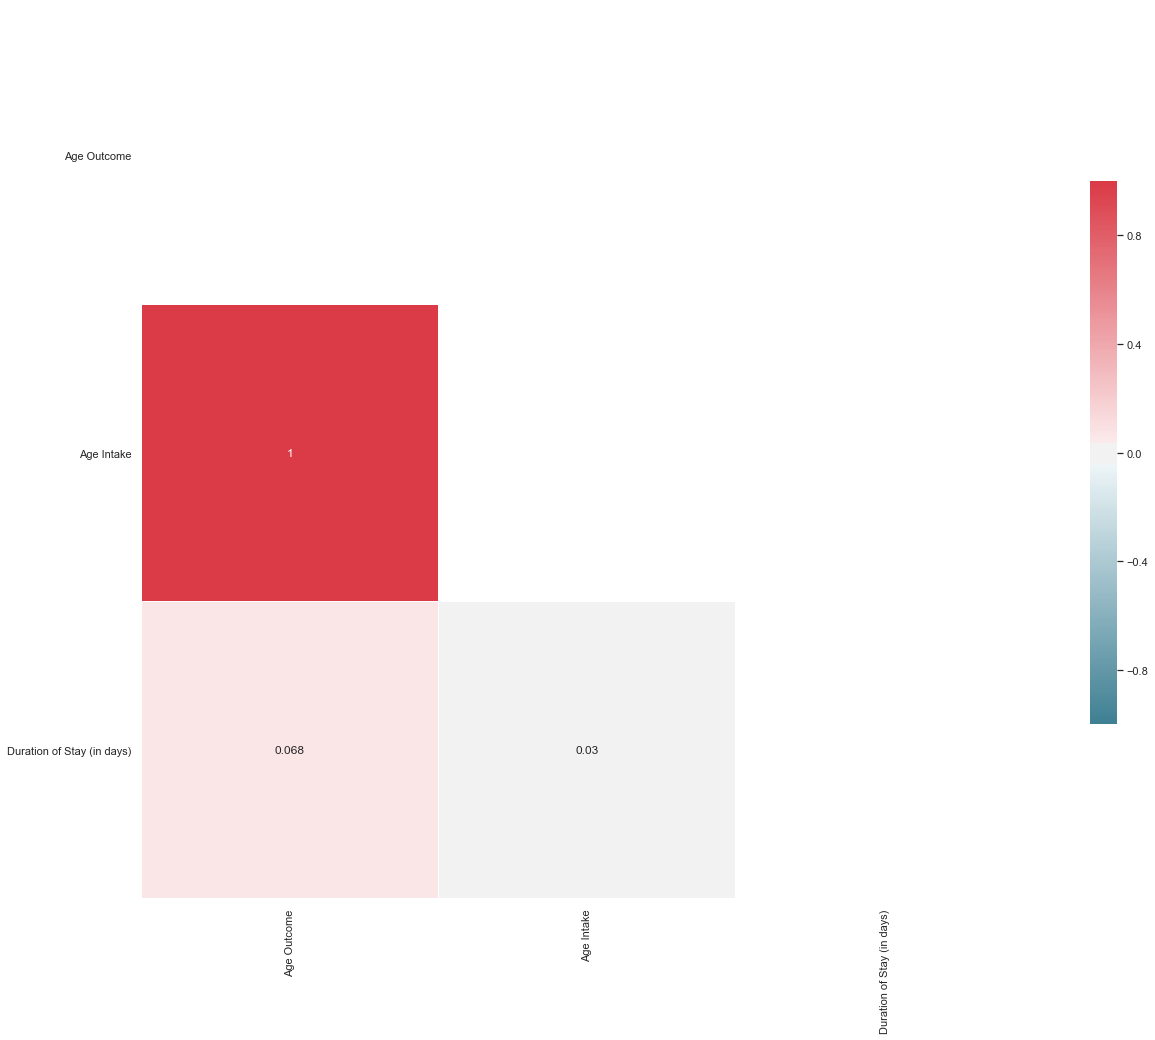

In [27]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

#### Interpretation of the results
- Strong correlations 
    - 'Age Outcome' and 'Age Intake' - This is to be expected as most age intake are the same and where they are not most are only by a matter of a few days - We only need to keep one of these features
  
- Weak correlations 
    - 'Duration of stay (in days)' - we will check this feature against the target later and if no strong correlation we can remove then

**Current status : Drop Age Outcome**
- We will label these as low_information_gain features


In [28]:
low_information_gain = ['Age Outcome']

### 1.2.2 Plot interaction between continuous features and target feature
- Here we will loop over each continuous feature and make a scatter plot against the target 'binary_outcome'
- We will discuss what we observe from these plots, e.g. which continuous features seem to be better at predicting the target feature
- We will choose a subset of continuous features we find promising (if any) and justify our choice.

Note: binary_outcome needs to be an int for these scatter plots, as we have prepared earlier

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


,binary_outcome
Age Intake,0.087377
Age Outcome,0.082567
Duration of Stay (in days),-0.122406


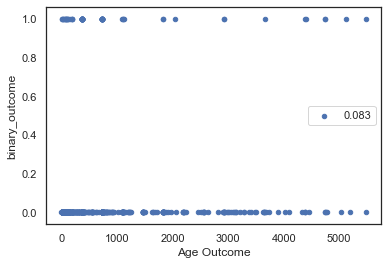

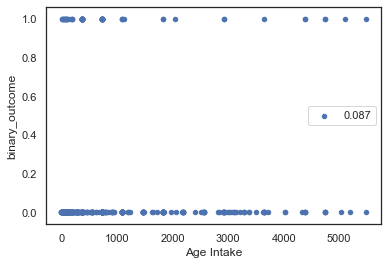

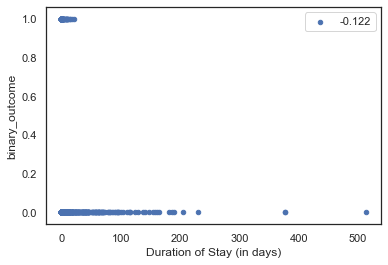

In [29]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_columns]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "binary_outcome"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="binary_outcome", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=["binary_outcome"]).sort_values("binary_outcome", ascending=False)
corr_df

#### 1.2.3 Interpretation of the results

| Low correlation | Medium correlation | High correlation |
|-----------------|--------------------|------------------|
| x <= 0.15       | 0.15 < x < 0.25    | x >= 0.25        |
| All features     | 0  features        | 0 features       |
| 100%            | -               | -              | 

- The strongest correlation here are both "age outcome" and "age intake", however still have low correlation values. 
   
- The correlation between "duration of stay (in days)" and the binary outcome target feature has a negative value. This is because many of the animals who have a negative outcome in the animal shelter stay for a couple of hours and not a full day which means the value is 0.

- All three continuous features values will be labelled as low_information_gain features, I will keep these values for now as I think they are still valuable fields to the dataset. 

- The impact of this decision will be evaluated in part 5.

List of low correlation features

In [30]:
# generate list of features for low correlation bin
low_correlation_features = []
for key, value in corr_dict.items():
    if value < 0.15 and value > -0.15:
        low_correlation_features.append(key)
low_correlation_features

['Age Outcome', 'Age Intake', 'Duration of Stay (in days)']

There are no high correlation features for the continuous features

### 1.2.3 Plot interaction between categorical features and target feature
- Here we will plot a pairwise interaction between each categorical feature against the target feature. 
- We will discuss what we observe from these plots, e.g., which categorical features seem to be better at predicting the target feature.
- We will choose a subset of categorical features we find promising (if any) and justify our choice.

Here we have 6 categorical features
- Found Location, Intake Type, Intake Condition, Animal Type_Intake, Sex upon Intake, Breed_Intake 
- A stacked bar plot for each will be created.

##### Create stacked bar plots for all categorical features


 Found Location
Index 	 Count
Austin (TX) 	 579
Travis (TX) 	 58
Manor (TX) 	 10
Cedar Park (TX) 	 3
Outside Jurisdiction 	 10
West Lake Hills (TX) 	 1
Williamson (TX)  	 1
Lago Vista (TX) 	 2
Del Valle (TX) 	 11
Jonestown (TX) 	 3
Pflugerville (TX) 	 11
Leander (TX) 	 1
Lakeway (TX) 	 1

 Intake Type
Index 	 Count
Stray 	 525
Public Assist 	 34
Owner Surrender 	 100
Wildlife 	 30
Euthanasia Request 	 2

 Intake Condition
Index 	 Count
Normal 	 595
Sick 	 37
Nursing 	 22
Injured 	 35
Aged 	 2

 Animal Type_Intake
Index 	 Count
Dog 	 348
Bird 	 6
Other 	 36
Cat 	 301

 Sex upon Intake
Index 	 Count
Male 	 328
Female 	 298
Unknown 	 65

 Breed_Intake
Index 	 Count
Labrador Retriever 	 32
Rare Breed 	 61
Pit Bull 	 48
Bat 	 20
Mixed Breed 	 46
Domestic S/M/L Hair 	 285
Chihuahua S/M/L Hair  	 43
Beagle 	 4
Border Collie 	 4
Pointer 	 3
Shepherd (Various)  	 31
Catahoula 	 4
Dachshund 	 9
Rottweiler 	 4
Australian Cattle Dog 	 6
Siamese 	 10
Miniature Schnauzer/Poodle/Pinscher  	 13
Racco

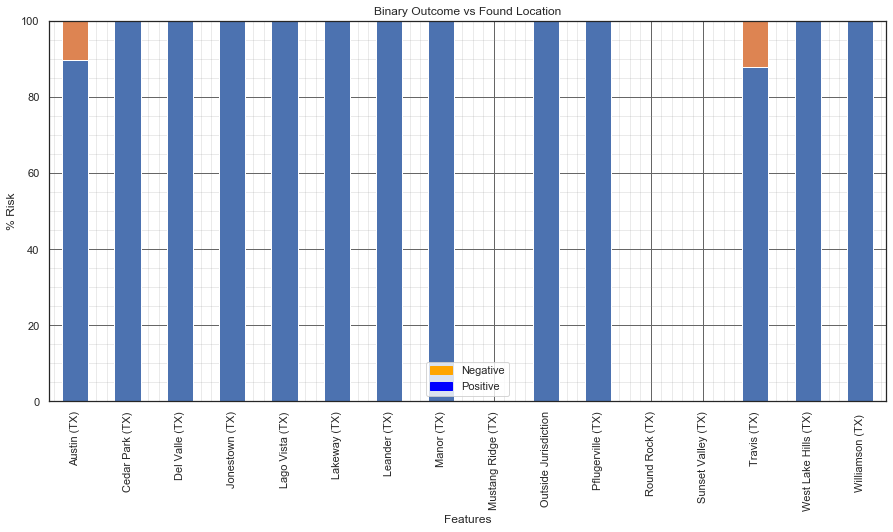

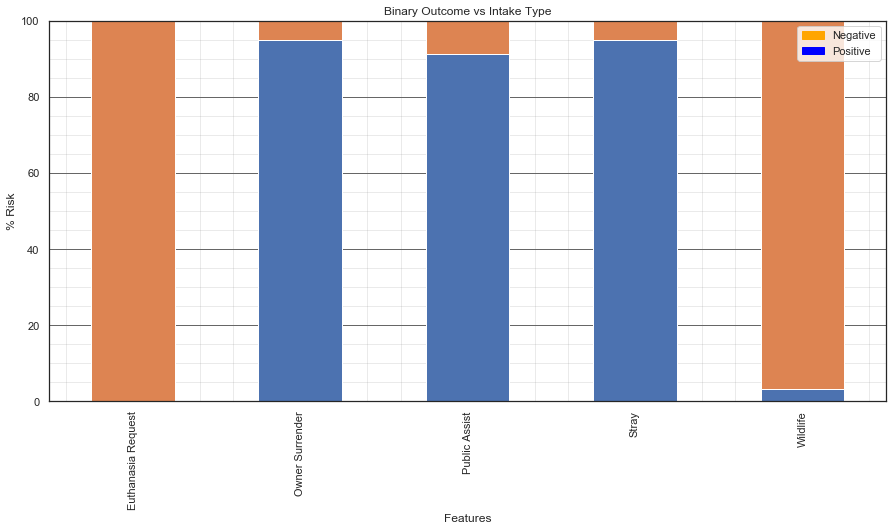

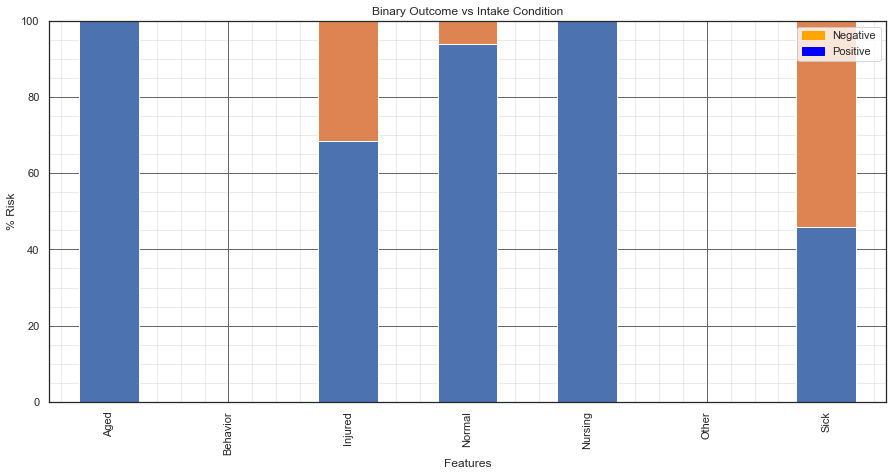

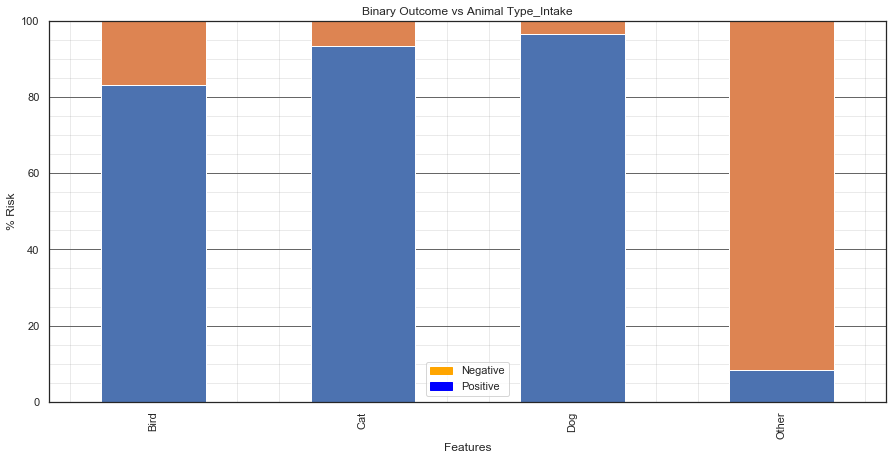

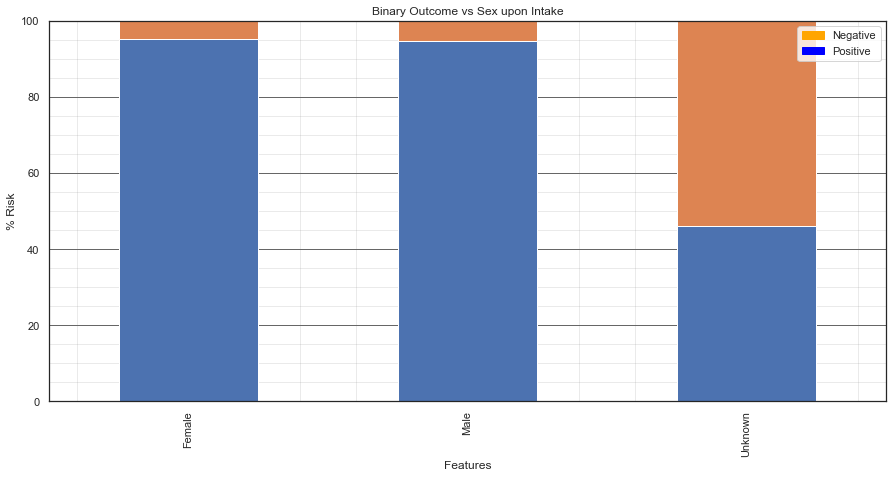

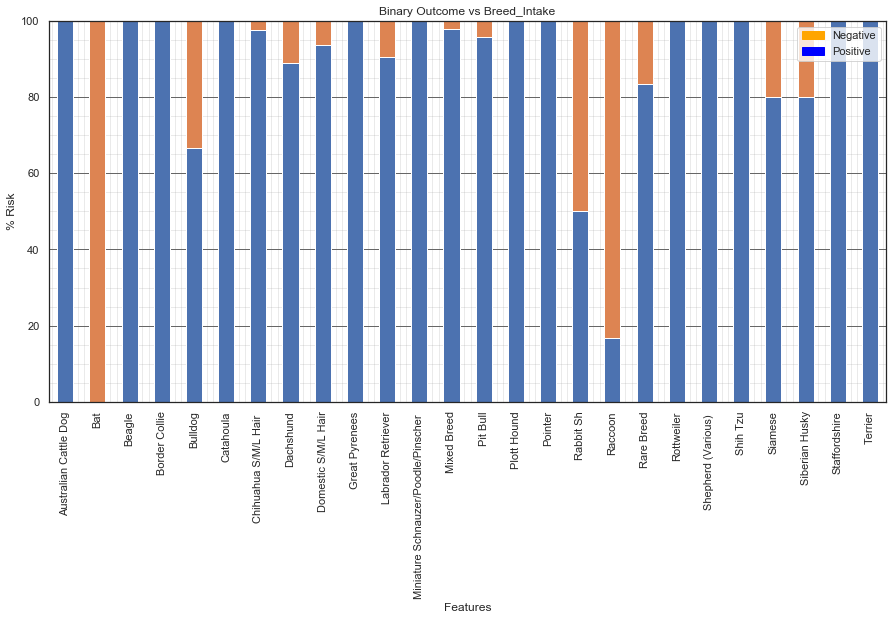

In [31]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")
#X_train[categorical_columns].columns

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)


# for each categorical feature create a stacked bar plot
for categorical_feature in categorical_columns:
    # Using code from the module lab
    
    animals = pd.unique(df_temp[categorical_feature].ravel())

    # add new column and set values to zero
    df_temp['percent'] = 0

    #print header
    print("\n", categorical_feature)
    print("Index \t Count")

    # for each delinquency category
    for i in animals:

        count = df_temp[df_temp[categorical_feature] == i].count()['binary_outcome']
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count_percentage

    group = df_temp[['percent',categorical_feature,'binary_outcome']].groupby([categorical_feature,'binary_outcome']).sum()

    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f"Binary Outcome vs {categorical_feature}", figsize=(15,7), grid=True)

    # add legend
    red_patch = mpatches.Patch(color='orange', label='Negative')
    blue_patch = mpatches.Patch(color='blue', label='Positive')
    my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

    # add gridlines
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    # add labels
    my_plot.set_xlabel("Features")
    my_plot.set_ylabel("% Risk")
    my_plot.set_ylim([0,100])
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)

#### Interpretation of the results
##### Binary Outcome vs Found Location
- A large majority of animals from the shelter found locations are Austin Texas, secondly to this Travis Texas. 
- Owing to this the negative binary outcome in these locations is higher than the other locations. 
- As these are more highly populated locations than other reported locations it is not suprising that there are more animals in the area being brought to the shelter. 

##### Binary Outcome vs Intake Type
- Observing the plots we can see that all Euthanasia Request intake types have a negative binary outcome value. This is as expected.
- Secondly to that for Wildlife intake types, almost all values have a negative outcome. 
- Stray, Owner Surrender and Public Assist all have a majority of positive outcomes.

##### Binary Outcome vs Intake Condition
- Observing the plot above we can see Sick intake condition has the highest risk of a negative outcome.
- The injured intake condition has values with negative outcome 
- The normal intake type also has values with negative outcome. These values will need more investigation as to why normal condition animals have a negative outcome ie. are they pests (rats, racoons)
- The sick and injured intake condition have the most negative outcome values which is to expected, normal intake condition values need more investigation

##### Binary Outcome vs Animal Type Intake
- Observing the plot above we can see Sick intake condition has the highest risk of a negative outcome.
- The injured intake condition has values with negative outcome 
- The normal intake type also has values with negative outcome. These values will need more investigation as to why normal condition animals have a negative outcome ie. are they pests (rats, racoons)
- The sick and injured intake condition have the most negative outcome values which is to expected, normal intake condition values need more investigation

##### Binary Outcome vs Sex upon intake 
- Most negative outcomes occur for unknown sex values
- These values are most likely wildlife and pests as their gender would not be known prior or reported

##### Binary Outcome vs Breed Intake
- Most negative outcomes occur for bats, racoons and rabbits as these are pests and wild. This is not suprising.
- Secondly to these breeds are Bulldogs. 


### 1.2.3 Define categorical features as high correlation features

In [32]:
# generate list of features for high correlation bin
high_correlation_features = []
for value in categorical_columns:
    high_correlation_features.append(value)
high_correlation_features

['Found Location',
 'Intake Type',
 'Intake Condition',
 'Animal Type_Intake',
 'Sex upon Intake',
 'Breed_Intake']

### Results
- For now all categorical features will be kept as they all show high correlation to the target feature. 
- The high correaltion variables are kept to be used in part 5 of the report.
- It is expected that Animal Type Intake, Intake Condition, and intake type will be the biggest indicators of the target feature but for now all categorical features will be kept


### 1.2.4 Summary & Drop Features

1. From Continuous vs Continuous plots (1.2.1) we identified the following to be dropped

In [33]:
low_information_gain

['Age Outcome']

2. From Continuous vs Target plots (1.2.2) we identified the following, although low correlation features, will not be dropped

In [34]:
low_correlation_features

['Age Outcome', 'Age Intake', 'Duration of Stay (in days)']

3. From Categorical vs Target (1.2.3) we identified the high correlation features
 

In [35]:
high_correlation_features

['Found Location',
 'Intake Type',
 'Intake Condition',
 'Animal Type_Intake',
 'Sex upon Intake',
 'Breed_Intake']

We will now drop these features
- Before dropping we will duplicate the original dataframe, df, and label it df_rev1
- We will drop features from this copy only (df_rev1)
- This will allow us to revert to the original dataset later if we decide to compare the performance of the reduced dataset (df_rev1) with the original dataset (df)

In [36]:
# drop all low correlation features
low_value_features = list(set(low_information_gain))
# before dropping make copy of original
df_rev1 = df.copy(deep=False)
# drop low value features
df_rev1.drop(low_value_features, 1, inplace=True)
print('\nRemaining columns:', df_rev1.columns)
print('\nNew shape:', df_rev1.shape)


Remaining columns: Index(['Found Location', 'Intake Type', 'Intake Condition',
       'Animal Type_Intake', 'Sex upon Intake', 'Breed_Intake',
       'binary_outcome', 'Age Intake', 'Duration of Stay (in days)'],
      dtype='object')

New shape: (988, 9)


In [37]:
df_rev1

,Found Location,Intake Type,Intake Condition,Animal Type_Intake,Sex upon Intake,Breed_Intake,binary_outcome,Age Intake,Duration of Stay (in days)
0,Austin (TX),Wildlife,Injured,Other,Unknown,Rare Breed,1,365,0
1,Austin (TX),Stray,Normal,Cat,Female,Domestic S/M/L Hair,0,76,6
2,Austin (TX),Owner Surrender,Normal,Cat,Female,Domestic S/M/L Hair,0,3652,21
3,Austin (TX),Stray,Normal,Cat,Female,Domestic S/M/L Hair,0,22,41
4,Austin (TX),Owner Surrender,Normal,Dog,Male,Terrier,0,2192,5
...,...,...,...,...,...,...,...,...,...
983,Austin (TX),Stray,Normal,Cat,Female,Domestic S/M/L Hair,0,46,5
984,Austin (TX),Stray,Normal,Cat,Unknown,Domestic S/M/L Hair,0,365,3
985,Austin (TX),Stray,Normal,Dog,Male,Terrier,0,45,42
986,Austin (TX),Stray,Normal,Cat,Male,Domestic S/M/L Hair,0,56,40


## 1.3 Prepare dataset for modeling
Now we have picked our descriptive features for the whole dataset, a number of additional steps will need to be taken to prepare the dataset for modeling 
- We will now convert the categorical variables into dummies variable to allow modeling
- We will then remove the redundant dummies which contain no additional information
- We will then set up the train test split again based on the dataset with the dummies included

#### Set up dummy features. 
This will split up each categorical feature into a number of dummy features. The data type changes to "uint8"

In [38]:
pd.options.display.max_rows = 1060
pd.options.display.max_columns =50

In [39]:
# set up dummies features
df_rev1 = pd.get_dummies(df_rev1, prefix=None)
df_rev1.dtypes

binary_outcome                                       int64
Age Intake                                           int64
Duration of Stay (in days)                           int64
Found Location_Austin (TX)                           uint8
Found Location_Cedar Park (TX)                       uint8
Found Location_Del Valle (TX)                        uint8
Found Location_Jonestown (TX)                        uint8
Found Location_Lago Vista (TX)                       uint8
Found Location_Lakeway (TX)                          uint8
Found Location_Leander (TX)                          uint8
Found Location_Manor (TX)                            uint8
Found Location_Mustang Ridge (TX)                    uint8
Found Location_Outside Jurisdiction                  uint8
Found Location_Pflugerville (TX)                     uint8
Found Location_Round Rock (TX)                       uint8
Found Location_Sunset Valley (TX)                    uint8
Found Location_Travis (TX)                           uin

#### Remove redundant features
We can see that in the categorical feature graphs some features are not relevant to the target feature and can be dropped. these features are "Found Location_Lago Vista (TX)", "Found Location_Williamson (TX)", "Found Location_Lakeway (TX)", "Found Location_Mustang Ridge (TX)", "Found Location_Round Rock (TX)", "Found Location_sunset Valley (TX)", "Intake Condition_Other", "Intake Condition_Behaviour". These features will now be dropped. 

In [40]:
#df_rev1
df_rev1 = df_rev1.drop(["Found Location_Lago Vista (TX)", "Found Location_Mustang Ridge (TX)", "Found Location_Round Rock (TX)", "Found Location_Sunset Valley (TX)", "Intake Condition_Other", "Intake Condition_Behavior"],1)

#### Continuous columns are:

In [41]:
continuous_columns = df_rev1.select_dtypes(include=['int64']).columns.tolist()
# remove the target "binary_outcome"
continuous_columns.pop(0)
continuous_columns

['Age Intake', 'Duration of Stay (in days)']

#### Categorical columns are:

In [42]:
categorical_columns = df_rev1.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns

['Found Location_Austin (TX)',
 'Found Location_Cedar Park (TX)',
 'Found Location_Del Valle (TX)',
 'Found Location_Jonestown (TX)',
 'Found Location_Lakeway (TX)',
 'Found Location_Leander (TX)',
 'Found Location_Manor (TX)',
 'Found Location_Outside Jurisdiction',
 'Found Location_Pflugerville (TX)',
 'Found Location_Travis (TX)',
 'Found Location_West Lake Hills (TX)',
 'Found Location_Williamson (TX) ',
 'Intake Type_Euthanasia Request',
 'Intake Type_Owner Surrender',
 'Intake Type_Public Assist',
 'Intake Type_Stray',
 'Intake Type_Wildlife',
 'Intake Condition_Aged',
 'Intake Condition_Injured',
 'Intake Condition_Normal',
 'Intake Condition_Nursing',
 'Intake Condition_Sick',
 'Animal Type_Intake_Bird',
 'Animal Type_Intake_Cat',
 'Animal Type_Intake_Dog',
 'Animal Type_Intake_Other',
 'Sex upon Intake_Female',
 'Sex upon Intake_Male',
 'Sex upon Intake_Unknown',
 'Breed_Intake_Australian Cattle Dog',
 'Breed_Intake_Bat',
 'Breed_Intake_Beagle',
 'Breed_Intake_Border Collie',


In [43]:
high_correlation_features = []
for value in categorical_columns:
    high_correlation_features.append(value)
high_correlation_features

['Found Location_Austin (TX)',
 'Found Location_Cedar Park (TX)',
 'Found Location_Del Valle (TX)',
 'Found Location_Jonestown (TX)',
 'Found Location_Lakeway (TX)',
 'Found Location_Leander (TX)',
 'Found Location_Manor (TX)',
 'Found Location_Outside Jurisdiction',
 'Found Location_Pflugerville (TX)',
 'Found Location_Travis (TX)',
 'Found Location_West Lake Hills (TX)',
 'Found Location_Williamson (TX) ',
 'Intake Type_Euthanasia Request',
 'Intake Type_Owner Surrender',
 'Intake Type_Public Assist',
 'Intake Type_Stray',
 'Intake Type_Wildlife',
 'Intake Condition_Aged',
 'Intake Condition_Injured',
 'Intake Condition_Normal',
 'Intake Condition_Nursing',
 'Intake Condition_Sick',
 'Animal Type_Intake_Bird',
 'Animal Type_Intake_Cat',
 'Animal Type_Intake_Dog',
 'Animal Type_Intake_Other',
 'Sex upon Intake_Female',
 'Sex upon Intake_Male',
 'Sex upon Intake_Unknown',
 'Breed_Intake_Australian Cattle Dog',
 'Breed_Intake_Bat',
 'Breed_Intake_Beagle',
 'Breed_Intake_Border Collie',


In [44]:
features = continuous_columns + categorical_columns
features

['Age Intake',
 'Duration of Stay (in days)',
 'Found Location_Austin (TX)',
 'Found Location_Cedar Park (TX)',
 'Found Location_Del Valle (TX)',
 'Found Location_Jonestown (TX)',
 'Found Location_Lakeway (TX)',
 'Found Location_Leander (TX)',
 'Found Location_Manor (TX)',
 'Found Location_Outside Jurisdiction',
 'Found Location_Pflugerville (TX)',
 'Found Location_Travis (TX)',
 'Found Location_West Lake Hills (TX)',
 'Found Location_Williamson (TX) ',
 'Intake Type_Euthanasia Request',
 'Intake Type_Owner Surrender',
 'Intake Type_Public Assist',
 'Intake Type_Stray',
 'Intake Type_Wildlife',
 'Intake Condition_Aged',
 'Intake Condition_Injured',
 'Intake Condition_Normal',
 'Intake Condition_Nursing',
 'Intake Condition_Sick',
 'Animal Type_Intake_Bird',
 'Animal Type_Intake_Cat',
 'Animal Type_Intake_Dog',
 'Animal Type_Intake_Other',
 'Sex upon Intake_Female',
 'Sex upon Intake_Male',
 'Sex upon Intake_Unknown',
 'Breed_Intake_Australian Cattle Dog',
 'Breed_Intake_Bat',
 'Breed_I

### Setting up the train/test split
- This is based on the dataset with dummy values
- The Target is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

#### Total features are:

In [45]:
# y is the target
y = df_rev1["binary_outcome"]
# X is everything else
X = df_rev1.drop(["binary_outcome"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_rev1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  988
training range (70%):	 rows 0 to 691
test range (30%): 	 rows 691 to 988


In [46]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
      Age Intake  Duration of Stay (in days)  Found Location_Austin (TX)  \
823         365                           2                           1   
632         123                           4                           1   
882        3217                           3                           1   
726         365                           1                           1   
675         128                           2                           1   

     Found Location_Cedar Park (TX)  Found Location_Del Valle (TX)  \
823                               0                              0   
632                               0                              0   
882                               0                              0   
726                               0                              0   
675                               0                              0   

     Found Location_Jonestown (TX)  Found Location_Lakeway (TX)  \
823                             

#### Reset the indexes of the training and test splits
- We can see from the X_train printout below that the indexes are no longer consecutive
- This is the same for y_train, X_test, y_test
- This will need to be dealt with next as it will effect merging of dataframes in the coming sections

We will now reset the index of all training and test dataframes

In [47]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,Age Intake,Duration of Stay (in days),Found Location_Austin (TX),Found Location_Cedar Park (TX),Found Location_Del Valle (TX),Found Location_Jonestown (TX),Found Location_Lakeway (TX),Found Location_Leander (TX),Found Location_Manor (TX),Found Location_Outside Jurisdiction,Found Location_Pflugerville (TX),Found Location_Travis (TX),Found Location_West Lake Hills (TX),Found Location_Williamson (TX),Intake Type_Euthanasia Request,Intake Type_Owner Surrender,Intake Type_Public Assist,Intake Type_Stray,Intake Type_Wildlife,Intake Condition_Aged,Intake Condition_Injured,Intake Condition_Normal,Intake Condition_Nursing,Intake Condition_Sick,Animal Type_Intake_Bird,...,Breed_Intake_Bat,Breed_Intake_Beagle,Breed_Intake_Border Collie,Breed_Intake_Bulldog,Breed_Intake_Catahoula,Breed_Intake_Chihuahua S/M/L Hair,Breed_Intake_Dachshund,Breed_Intake_Domestic S/M/L Hair,Breed_Intake_Great Pyrenees,Breed_Intake_Labrador Retriever,Breed_Intake_Miniature Schnauzer/Poodle/Pinscher,Breed_Intake_Mixed Breed,Breed_Intake_Pit Bull,Breed_Intake_Plott Hound,Breed_Intake_Pointer,Breed_Intake_Rabbit Sh,Breed_Intake_Raccoon,Breed_Intake_Rare Breed,Breed_Intake_Rottweiler,Breed_Intake_Shepherd (Various),Breed_Intake_Shih Tzu,Breed_Intake_Siamese,Breed_Intake_Siberian Husky,Breed_Intake_Staffordshire,Breed_Intake_Terrier
0,365,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,123,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,3217,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,365,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,128,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


The datasets are now ready for modeling

## (2) Linear Regression Model
#### 2.1 Train a linear regression model using only the descriptive features selected from part 1 above

In [48]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

#### 2.2 Print out the coefficients learned by the model


In [49]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['Age Intake', 'Duration of Stay (in days)',
       'Found Location_Austin (TX)', 'Found Location_Cedar Park (TX)',
       'Found Location_Del Valle (TX)', 'Found Location_Jonestown (TX)',
       'Found Location_Lakeway (TX)', 'Found Location_Leander (TX)',
       'Found Location_Manor (TX)', 'Found Location_Outside Jurisdiction',
       'Found Location_Pflugerville (TX)', 'Found Location_Travis (TX)',
       'Found Location_West Lake Hills (TX)',
       'Found Location_Williamson (TX) ', 'Intake Type_Euthanasia Request',
       'Intake Type_Owner Surrender', 'Intake Type_Public Assist',
       'Intake Type_Stray', 'Intake Type_Wildlife', 'Intake Condition_Aged',
       'Intake Condition_Injured', 'Intake Condition_Normal',
       'Intake Condition_Nursing', 'Intake Condition_Sick',
       'Animal Type_Intake_Bird', 'Animal Type_Intake_Cat',
       'Animal Type_Intake_Dog', 'Animal Type_Intake_Other',
       'Sex upon Intake_Female', 'Sex upon Intake_Male',
     

#### 2.3 Interpreting the linear regression model

- Linear regression is a linear approach to modeling the relationship between between the target (dependent variable) and other descriptive features (independent variables)
    - It finds the line of best fit the describes the relationship between the target and predictors 
    - It is an error-based training model which means it measures how well this initial model performs when making predictions for examples in a training dataset. It is calculated by minimising the overall error
- It is described by a set of parameters also known as weights (e.g., w_0, w_1, ..., w_n, where n is the number of features). The predictive function takes the following form:
    - $target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $
    - The output of this formula will be a continuous value that can be less than 0 and higher than 1
- We can see the calculated intercept is 0.317 (w_0)
    - This is the starting point. i.e. if all other coefficients are zero then the model result will be 0.317
    - This can be thought of as where the model line intercepts the y axis
- We can see all the coefficients for each feature
    - These are zipped together in a single list for ease of inspection.
    - The sum of all the feature*coefficients + intercept will result in the model prediction  
- We cannot make a direct comparison based on the value of the coefficients as it is tied directly to the range of each feature.
    - If all features were normalized this would be possible to see directly
    - However if we multiply each feature by its max range we can get an idea of its max possible impact on the prediction.  We could look at median also.
    
It is important to note that the output from a linear regression model is not suited to the classification problem that we are trying to solve.
- The output is not a probability and an additional thresholding step is necessary to convert the output into a binary classification
- We will threshold the output so that any values >=0.5 will be cast to 1, any values <0.5 will be cast to 0

It is worth mentioning the effect outliers can have on linear regression output. 
- Consider the effect of the outlier in the graph below on the regression line and what values fall into each threshold category. 
- The outlier will have a huge effect on values near the threshold. 
- This will be discussed further in the next section.


#### 2.4 Printing 100 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 100 training examples. 
- We will threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 
    - If value is >= 0.5 it is cast to 1, if < 0.5 it is cast to 0

In [50]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0                0        0.0
1                0        0.0
2                0        0.0
3                1        1.0
4                0        0.0
5                0        0.0
6                0        0.0
7                0        0.0
8                0        0.0
9                0        0.0
10               0        0.0
11               0        0.0
12               0        0.0
13               0        0.0
14               1        1.0
15               0        0.0
16               0        0.0
17               0        0.0
18               0        0.0
19               0        0.0
20               0        0.0
21               0        0.0
22               0        0.0
23               1        1.0
24               0        0.0
25               1        0.0
26               0        0.0
27               0        0.0
28               0        0.0
29               0        0.0
30               0    

#### 2.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss findings based on these measures

In [51]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9536903039073806
Confusion matrix: 
 [[624   1]
 [ 31  35]]
Classification report:
                precision    recall  f1-score   support

           0       0.95      1.00      0.97       625
           1       0.97      0.53      0.69        66

    accuracy                           0.95       691
   macro avg       0.96      0.76      0.83       691
weighted avg       0.95      0.95      0.95       691



##### Interpretation of results
- Accuracy
    - This is simply stating how often the model is correct. We have an accuracy of 95%
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number that is predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number that is predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number that is predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number that is predicted 1 that is actually 1
- Precision - How good the model is at predicting the positive class
    - What % of the predicted positive are actually positive
    - It is the number values correctly predicted positive over the total number of  positive values
    - Precision Positive is 0.95
    - Precision Negative is 0.97
- Recall
    - What % of the positive values did we predict
    - Is the number correctly predicted positive over the total number actual positive
    - Recall Positive is 1.0
    - Recall Negative is 0.53
- F1 Score
    - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.97
    - F1 Score Negative is 0.69

Summary
- Theses values are good. 
- The model is much better at predicting the positive outcome
- This makes sense as the model has more positive data to learn from - it is the majority class.
- This is useful as overestimating negative outcomes may be a waste of services or facilities if the shelter if they are expecting more negative outcomes than will occur, and other shelters are lacking these facilities.
- However, in our opinion for this case, is more useful as it is better to have predict a negative outcome where there is not one than to predict a positive outcome where there is a negative in the end. 
- It is better for the shelter to overestimate negative outcomes as they will have the facilities to provide for unforseen events.

#### 2.6 Evaluate the model using the hold-out (30% examples) test set
- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual binary outcome vs predicted based on test data

In [52]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0                0        0.0
1                0        0.0
2                0        0.0
3                0        0.0
4                1        0.0
5                0        0.0
6                0        0.0
7                0        0.0
8                1        1.0
9                0        0.0
10               0        0.0
11               0        0.0
12               0        0.0
13               0        0.0
14               0        0.0
15               0        0.0
16               0        0.0
17               0        0.0
18               0        0.0
19               0        0.0
20               0        0.0
21               0        0.0
22               0        0.0
23               0        0.0
24               0        0.0
25               1        1.0
26               0        0.0
27               0        0.0
28               0        0.0
29               1        1.0
30               0    

##### Evaluation metrics based on test data

In [53]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9393939393939394
Confusion matrix: 
 [[264   3]
 [ 15  15]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.95      0.99      0.97       267
           1       0.83      0.50      0.62        30

    accuracy                           0.94       297
   macro avg       0.89      0.74      0.80       297
weighted avg       0.93      0.94      0.93       297


==================== Train Data ======================
Accuracy:  0.9536903039073806
Confusion matrix: 
 [[624   1]
 [ 31  35]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.95      1.00      0.97       625
           1       0.97      0.53      0.69        66

    accuracy                           0.95       691
   macro avg       0.96      0.76      0.83       691
weighted avg       0.95      0.95      0.95       691



**Interpretation of test results and comparison with training results**
- Accuracy
    - The accuracy of the test data is marginally lower 93.93% vs 95.36%. 
- Precision
    - The precision score for predicting the positive case has remained the same at 95% 
    - The precision score for predicting the negative case has reduced from 97% to 83%.
- Recall
    - The recall score for predicting the positive case has reduced slightly from 100% to 99%.
    - The recall score for predicting the negative case has reduced from 53% to 50%.
- F1
    - The f1 score for predicting the positive case has remained the same at 97% 
    - The f1 score for predicting the negative case has reduced from 69% to 62%.

**Summary**
- These values are a little higher than expected as we are now testing the model prediction on data it has not seen before
- This is a good sign that the model is generalising
- More comparisons need to be made and this is where cross validation steps in

#### 2.7 Cross validation
- We will now perform cross validation on the linear regression model. 
- Here we perform the same evaluation as above but multiple times
- Each time the data is shuffled so we get a slightly different view of the data for training and testing
- This works well for evaluating on a limited set of data
- We will store the results in a dictionary for later use

First we need to create a function to perform this cross validation. Sklearn does not provide one for linear regression. However it does for logistic and random forests models
- Cross validation Function can be seen below

In [54]:
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

We will now create an additional function to perform 10 fold cross validation and store results into a dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [55]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

Preform 10 fold cross validation using cross_val_LinReg_DF function
- Results summarised below

In [56]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.947475
precision,0.902720
recall,0.526923
f1,0.659185


These results are marginally lower than previous results but this is expected. We have taken the mean of 10 sets of results. 

## (3) Logistic Regression   

#### 3.1 Train a logistic regression model using only the descriptive features selected from part 1 above

In [57]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

#### 3.2 Print out the coefficients learned by the model

In [58]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['Age Intake', 'Duration of Stay (in days)',
       'Found Location_Austin (TX)', 'Found Location_Cedar Park (TX)',
       'Found Location_Del Valle (TX)', 'Found Location_Jonestown (TX)',
       'Found Location_Lakeway (TX)', 'Found Location_Leander (TX)',
       'Found Location_Manor (TX)', 'Found Location_Outside Jurisdiction',
       'Found Location_Pflugerville (TX)', 'Found Location_Travis (TX)',
       'Found Location_West Lake Hills (TX)',
       'Found Location_Williamson (TX) ', 'Intake Type_Euthanasia Request',
       'Intake Type_Owner Surrender', 'Intake Type_Public Assist',
       'Intake Type_Stray', 'Intake Type_Wildlife', 'Intake Condition_Aged',
       'Intake Condition_Injured', 'Intake Condition_Normal',
       'Intake Condition_Nursing', 'Intake Condition_Sick',
       'Animal Type_Intake_Bird', 'Animal Type_Intake_Cat',
       'Animal Type_Intake_Dog', 'Animal Type_Intake_Other',
       'Sex upon Intake_Female', 'Sex upon Intake_Male',
     

#### 3.3 Interpreting the results 

The main differences between the logistic regression function and the linear regression function above are: 
- The output of the logistic function is a probability, a value between 0 and 1
- The output of the linear function is a continuous value that is not a probability<br>
There are also numerous similarities between the two:
   - Initially using the logistic regression function linear regression function, we find the line of best fit
    - We then pass this equation through what is called a sigmoid function
    - This sigmoid function will output a value bound between 0 and 1. It is a probability
    - The model then applies a threshold to this probability so that if is is >= 0.5 its cast to 1 and if it is <0.5 it is cast to 0
    - All of these steps are carried out within the logistic regression function, however the threshold value can be adjusted up or down depending on the problem you are trying to solve.

The model estimated in logistic regression is given by the logistic function: <br>
$probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$ <br>
where $logistic(x)$ is defined as: $logistic(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$

- From the values above can see the calculated intercept is -0.4965
    - This is the starting point. i.e. if all other coefficients were zero then the value for 'x' would be -0.438
    - This is the input to the logistic function and the logistic function will then calculate the probability and threshold based on this.
- We can see all the coefficients for each features
    - These are zipped together in a single list for ease of inspection.
    - The effect of these on the value 'x' is the same as for linear regression
    - Only when the value 'x' is fed into the logistic function do we see the real difference between the to methods.
    
    
The benefit to using logistic regression over other models is its ability to handle outliers
- As seen in linear regression, outliers can significantly skew what values fall within each threshold point. 
- Just a single outlier can disturb the whole linear regression predictions. 
- When using logistic regression, values near the threshold point will not be impacted significantly


#### 3.4 Printing 100 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 100 training examples based on training data

In [59]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(100))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0                0          0
1                0          0
2                0          0
3                1          1
4                0          0
5                0          0
6                0          0
7                0          0
8                0          0
9                0          0
10               0          0
11               0          0
12               0          0
13               0          0
14               1          1
15               0          0
16               0          0
17               0          0
18               0          0
19               0          0
20               0          0
21               0          0
22               0          0
23               1          1
24               0          0
25               1          0
26               0          0
27               0          0
28               0          0
29               0          0
30               0    

#### 3.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [60]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.959479015918958
Confusion matrix: 
 [[624   1]
 [ 27  39]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98       625
           1       0.97      0.59      0.74        66

    accuracy                           0.96       691
   macro avg       0.97      0.79      0.86       691
weighted avg       0.96      0.96      0.95       691



Interpretation of results
- Accuracy
    - We have an accuracy of 95%
- Precision - How good model is a prediction the positive class
    - Precision Positive is 0.96
    - Precision Negative is 0.95
- Recall - What % of the positive values did we predict
    - Recall Positive is 1.0
    - Recall Negative is 0.59
- F1 Score - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.98
    - F1 Score Negative is 0.73


Summary
- These values seem reasonable
- Accuracy is in line with the linear regression model
- The logistic model is also a little better at predicting the negative class.

#### 3.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual Binary Outcome vs predicted based on test data

In [61]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0                0          0
1                0          0
2                0          0
3                0          0
4                1          0
5                0          0
6                0          0
7                0          0
8                1          1
9                0          0
10               0          0
11               0          0
12               0          0
13               0          0
14               0          0
15               0          0
16               0          0
17               0          0
18               0          0
19               0          0


Evaluation based on test data

In [62]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9427609427609428
Confusion matrix: 
 [[265   2]
 [ 15  15]]
Classification report:
                precision    recall  f1-score   support

           0       0.95      0.99      0.97       267
           1       0.88      0.50      0.64        30

    accuracy                           0.94       297
   macro avg       0.91      0.75      0.80       297
weighted avg       0.94      0.94      0.94       297

==================== Train Data =======================
Accuracy:  0.959479015918958
Confusion matrix: 
 [[624   1]
 [ 27  39]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98       625
           1       0.97      0.59      0.74        66

    accuracy                           0.96       691
   macro avg       0.97      0.79      0.86       691
weighted avg       0.96      0.96      0.95       691



Interpretation of test results and comparison with training results 
- Accuracy
    - The accuracy of the test data is lower 94.27% vs 95.8%. 
- Precision
    - The precision score for predicting the positive case has increased slightly from 95% to 96%.
    - The precision score for predicting the negative case has increased from 88% to 95%.
- Recall
    - The recall score for predicting the positive case has increased slightly from 99% to 100%.
    - The recall score for predicting the negative case has reduced from 50% to 59%.
- F1
    - The f1 score for predicting the positive case has increased slightly from 97% to 98%.
    - The f1 score for predicting the negative case has increased from 64% to 73%.

Summary
- These values are good.
- The accuracy level have dropped which is normal as we are testing the model on data it has not see before.
- This is a good sign that the model is generalizing.
- More comparisons need to be made and this is where cross validation steps in.

#### 3.7 Cross validation
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [63]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarised below

In [64]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.949472
precision,0.879048
recall,0.575556
f1,0.684744


These results are in line with the previous results. We have taken the mean of 10 sets of results. 

## (4) Random Forest Model

### 4.1 Train a random forest model using only the descriptive features selected from part 1 above 
- A random forest model will now be trained on our test data. 
- We use the RandomForestClassifier() function. 
- The random state will be set to 1 to allow the results to be repeated

In [65]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

### 4.2 Understanding the Random Forest model

- A random forest is an ensemble model. It is made up of a collection of decision trees
- Decision tree
    - Each Decision Tree algorithm is trained on a subset of the original data
    - A decision tree is a set of if-then-else rules based on splitting the data based on specific features
    - The decision on which feature to split on is based on the information gain (Gini index). 
    - The tree will always split on the feature that gives the highest information gain
    - The feature with the highest information gain will sit at the root of each decision tree
    - Each decision tree will be a single prediction
- Random Forest 
    - The random forest is made up of a number of decision trees
    - The output of the random forest is base on the majority output of all decision trees combined
    - This gives reliable results but can be hard to interpret
    - The random forest will keep track of the importance of features in terms of information gain, which we will see
    
We will now look at an example of a single decision tree to get a better understanding

####  4.2.1  Train Decision tree
We will train 2 decision trees, with the same test data 
- One with max_depth=4 and the other max_depth=10
- Max depth determines how deep a decision tree can go before it must give an answer

In [66]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc4.fit(X_train, y_train)
dtc10.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')
Max depth 10: 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')


####  4.2.2  Display Decision tree
We will create graph of each tree and store as an image

In [67]:
import pydotplus

In [68]:
# create a Graphviz png

with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc10, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png


We can see below the decision tree with max_depth=4
- We can see the root is Animal Type intake Other at value 0.5 - This splits the data best i.e. has the highest information gain
- For each split the the model selects the next best feature
- This continues until it reaches a leaf node where the data cannot be split anymore
- The output of this is the prediction
- We can see one path below is resolved in 2 branches
    - Animal Type Intake Other <= 0.5 ->  Intake Type_Owner Surrender <= 0.5 -> Resolved to TRUE
    - Note: only 1 entry meets this requirement.
    - All other entries need additional branches to be resolved with a maximum being set to 4.

<img src="DecisionTree4.png">

Viewing a decision tree with maxdepth=10 shows how complicated this model becomes 
- This is only one example of a decision tree. 
- A Random forests has 100 decision trees by default
- Each decision tree is given a slightly different view of the data

<img src="DecisionTree10.png">

#### 4.2.3 Interpretation of the random forest model
As mentioned above the random forest will keep track of the importance of features
- We can see from the dataframe below the results of this feature importance ranking
- The more important features are the features that the random forest has identified as having higher information gain
- This list is the combined result of the 100 decision trees that make up the random forest model
- This feature ranking will help us in our optimisation process going forward
    - What are the best features to keep?
    - What features can be safely dropped without loosing information?

In [69]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
0,Age Intake,1.747092e-01
27,Animal Type_Intake_Other,1.394835e-01
1,Duration of Stay (in days),1.392639e-01
18,Intake Type_Wildlife,1.021078e-01
30,Sex upon Intake_Unknown,6.561994e-02
32,Breed_Intake_Bat,6.125490e-02
23,Intake Condition_Sick,4.647797e-02
17,Intake Type_Stray,3.601507e-02
21,Intake Condition_Normal,3.234065e-02
20,Intake Condition_Injured,2.070071e-02


We can see from the list above that many of the features provide little information gain. Though the features providing no information gain have been dropped from the dataframe. 

### 4.4 Printing 100 predicted target features and evaluate the prediction 
- Here we will print the predicted target feature value for the first 100 training examples. 

In [70]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(100)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


### 4.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [71]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9971056439942113
Confusion matrix: 
 [[625   0]
 [  2  64]]
Classification report:
                precision    recall  f1-score   support

           0       1.00      1.00      1.00       625
           1       1.00      0.97      0.98        66

    accuracy                           1.00       691
   macro avg       1.00      0.98      0.99       691
weighted avg       1.00      1.00      1.00       691



Interpretation of results
- The model has learned the results. This is clearly overfitting

### 4.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual RiskPerformance vs predicted based on test data

In [72]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
5,0,0
6,0,0
7,0,0
8,1,1
9,0,0


Evaluation metrics based on test data

In [73]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9427609427609428
Confusion matrix: 
 [[265   2]
 [ 15  15]]
Classification report:
                precision    recall  f1-score   support

           0       0.95      0.99      0.97       267
           1       0.88      0.50      0.64        30

    accuracy                           0.94       297
   macro avg       0.91      0.75      0.80       297
weighted avg       0.94      0.94      0.94       297

==================== Train Data =======================
Accuracy:  0.9971056439942113
Confusion matrix: 
 [[625   0]
 [  2  64]]
Classification report:
                precision    recall  f1-score   support

           0       1.00      1.00      1.00       625
           1       1.00      0.97      0.98        66

    accuracy                           1.00       691
   macro avg       1.00      0.98      0.99       691
weighted avg       1.00      1.00      1.00       691



Interpretation of test results and comparison with training results 
- The accuracy for the test is much lower as we are not testing the model with data it has not see before
- The scores seem reasonable and are in line with the other models test results

### 4.7 Cross validation
- We will preform cross validation and store the results in a dictionary for later use

In [74]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

##### The results for Random Forests are summarized below

In [75]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.943390
precision,0.827619
recall,0.546667
f1,0.649790


The results above are inline with expectation
- The accuracy is the same
- The recall and f1 are all a little lower but in line with the other models

### 4.8 Out of bag accuracy
- This is the out of bag error estimate 
- It is an internal error estimate of a random forest as it is being constructed.
- It is used as an additional measure and should be line with the cross validation results
- This is generally expected to be the lowest

In [76]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.9435600578871202

This value is in line with the Cross validation results above

## 5 Improving Predictive Models

### 5.1 Which model of the ones trained above performs better at predicting the target feature? 
- All models preform almost identical on the test dataset +/- 1%
- Summary of the results so far can be seen below (based on predicting good outcome (binary Outcome=0))
- Note these results are for a subset of the original features i.e. In part 1 we dropped many of the low correlation features
    - In part 5.3 we will review the impact to the decisions taken in part 1

In [77]:
ResultsDF = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.947475,0.949472,0.943390
precision,0.902720,0.879048,0.827619
recall,0.526923,0.575556,0.546667
f1,0.659185,0.684744,0.649790


### 5.2 Is the model more accurate than a simple model that always predicts the majority class
- We will compare our results above to a simple model which predicts for the majority class
- First we will get the breakdown of the test dataset and see which is the majority class

In [78]:
good_count = y_test[y_test == 1].count()
bad_count = y_test[y_test == 0].count()
total = good_count+ bad_count
print(f'From original dataset: \t\tCount {total}')
print(f'Total number never delinquent:\t {good_count}\t{round(good_count/len(y_test)*100,2)}%')
print(f'Total number delinquent:\t {bad_count}\t{round(bad_count/len(y_test)*100,2)}%')

From original dataset: 		Count 297
Total number never delinquent:	 30	10.1%
Total number delinquent:	 267	89.9%


- We can see the majority class is 0 or binary_outcome=Bad 
- We will now generate scores for predicting the majority class

In [79]:
# generate array of 297 zeros (length of test dataset)
majority = np.zeros(297)
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual
print("Accuracy: ", metrics.accuracy_score(y_test, df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, df_majorityClass))
print("Classification report:\n ", metrics.classification_report(y_test, df_majorityClass))

Accuracy:  0.898989898989899
Confusion matrix: 
 [[267   0]
 [ 30   0]]
Classification report:
                precision    recall  f1-score   support

           0       0.90      1.00      0.95       267
           1       0.00      0.00      0.00        30

    accuracy                           0.90       297
   macro avg       0.45      0.50      0.47       297
weighted avg       0.81      0.90      0.85       297



- For predicting good outcome the simple model fails completely as expected
- For predicting the bad outcome the simple model fares much better but still worse than all the other models outlined above
    - The precision is the same as the accuracy in this case - i.e. how good is it at predicting 0
    - The recall is 100% as all of the actual 0 values were predicted 0
    - The f1 is .95 with the weighted average .85.

### 5.3 Compare Model performance using different feature subsets 
#### 5.3.1 All features
- We will now repeat the tests using all features 
- First we set up the dataframe using the original features

In [80]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)
# set X,y
y = df_all["binary_outcome"]
X = df_all.drop(["binary_outcome"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  64


With the dataframe now setup we will generate new set of results based on all the features
- This operation is simplified as we have set up functions in part 2,3,4 to allow cross validated scores to be returned in dataframes 

In [81]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures


,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.942761,0.949472,0.944401
precision,0.844047,0.879048,0.847143
recall,0.519516,0.575556,0.546667
f1,0.636833,0.684744,0.654958


#### 5.3.2 High correlation features only
- We will now repeat the tests using the high correlation features identified in part (1.2.3)
- Again we set up the dataframe but now we use the list of high_correlation_features only

In [82]:
df_highCorr = pd.get_dummies(df)
y = df_highCorr["binary_outcome"]
X = df_highCorr[high_correlation_features]
print("Number of features: ", len(X.columns))

Number of features:  55


In [83]:
# calculate Linear regression, logistic regression, random forest results again
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_HighCorrFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_HighCorrFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.944108,0.949462,0.941329
precision,0.850170,0.925000,0.791071
recall,0.527220,0.534444,0.555556
f1,0.647061,0.670714,0.647467


### 5.3.3 Comparison of feature set so far

In [84]:
print("\nScores using all features: 64 features (0 features dropped)")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features: 61 features (3 features dropped - from part 1)")
print("===================================================================")
print(ResultsDF)
print("\nScores using high Correlation features only: 61 features (3 features dropped)")
print("===================================================================")
print(ResultsDF_HighCorrFeatures)


Scores using all features: 64 features (0 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.942761             0.949472        0.944401
precision           0.844047             0.879048        0.847143
recall              0.519516             0.575556        0.546667
f1                  0.636833             0.684744        0.654958

Scores using subset of features: 61 features (3 features dropped - from part 1)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.947475             0.949472        0.943390
precision           0.902720             0.879048        0.827619
recall              0.526923             0.575556        0.546667
f1                  0.659185             0.684744        0.649790

Scores using high Correlation features only: 61 features (3 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.944108             0.949462    

We can see from the above set of results that there is very little reduction in accuracy as we remove very few low value features. There is a slight improvement in th Randon_Forest models.

### 5.4 Further optimisations
- There are two possible options for optimizing the linear and logistic regression models
    - Deriving new features - All of the derived features proposed in homework 1 performed poorly and so additional features will not be proposed. However there could be an improved way of using current features. 
    - Further reviewing the existing features to find the best combination - This has already been attempted 
- We will therefore focus in the random forest model to see what optimization is possible. We will look at the following:
    1. Find best performing Max_Depth of decision tree while keeping accuracy high - reduce potential for overfitting and speed up model 
    2. Find lowest number estimators while keeping accuracy high- reduce unnecessary estimators as will slow down the model
    3. Find best preforming list of features ranked by feature importance - As we know there are many feature that add little the the model. Removing them will help generalise the model
        - Results here can be applied to all models 

#### 5.4.1 Optimise Max Depth
**Note: This calculation may take some time**

In [85]:
# setup dataframe
df_all = pd.get_dummies(df)
y = df_all["binary_outcome"]
X = df_all.drop(["binary_outcome"],1)

# initialised empty daraframe
RandomForest_Depth = pd.DataFrame()

# calculate cross val score incrementing max depth by 1 each iteration
# append results to dataframe
for i in range(1,11):
    df1 = cross_val_RandomForest_DF(X,y,i)
    df1.rename(columns={'Random_Forests':f'depth={i}'}, inplace=True)
    RandomForest_Depth = pd.concat([RandomForest_Depth, df1], axis=1)

# same calculation but use no max depth this time
no_max_depth = cross_val_RandomForest_DF(X,y)
no_max_depth.rename(columns={'Random_Forests':f'no_max_depth'}, inplace=True)
RandomForest_Depth = pd.concat([RandomForest_Depth, no_max_depth], axis=1)
RandomForest_Depth

,depth=1,depth=2,depth=3,depth=4,depth=5,depth=6,depth=7,depth=8,depth=9,depth=10,no_max_depth
accuracy,0.908912,0.944380,0.948451,0.947441,0.949451,0.949451,0.949451,0.950472,0.950482,0.949472,0.944401
precision,0.400000,0.980000,0.983333,0.958333,0.958333,0.958333,0.958333,0.950000,0.946667,0.930000,0.847143
recall,0.060000,0.441111,0.484444,0.484444,0.504444,0.504444,0.504444,0.524444,0.525556,0.525556,0.546667
f1,0.100699,0.600513,0.639487,0.636190,0.655238,0.655238,0.655238,0.670714,0.670119,0.665952,0.654958


The accuracy, precision, recall and f1 jumps greatly after the extension from max depth 1 to max depth 2. This shows the impact adding extra information provides for the ananlysis of a dataset. 
We can see from above that the sweet spot appears to be with a max depth of 8. It does let us know that there is little to be gained by having max_depth=None.


#### 5.4.2 Optimise Number of estimators
**Note: This calculation may take some time**

In [86]:
# setup dataframe
df_all = pd.get_dummies(df)
y = df_all["binary_outcome"]
X = df_all.drop(["binary_outcome"],1)

# initialised empty daraframe
RandomForest_Estimators = pd.DataFrame()

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

for item in n_estimators:
    df1 = cross_val_RandomForest_DF(X,y,estimators=item)
    df1.rename(columns={'Random_Forests':f'estimators={item}'}, inplace=True)
    RandomForest_Estimators = pd.concat([RandomForest_Estimators, df1], axis=1)

RandomForest_Estimators

,estimators=1,estimators=2,estimators=4,estimators=8,estimators=16,estimators=32,estimators=64,estimators=100,estimators=200
accuracy,0.908994,0.939381,0.941370,0.940309,0.943370,0.943380,0.945401,0.944401,0.946441
precision,0.552677,0.843333,0.800476,0.806151,0.821310,0.817738,0.841429,0.847143,0.860714
recall,0.544444,0.463333,0.546667,0.545556,0.546667,0.545556,0.556667,0.546667,0.556667
f1,0.543952,0.594405,0.642647,0.637652,0.645754,0.649902,0.662913,0.654958,0.667143


We can see from the above dataframe that accuracy continues to improve with increasing number of estimators. I hoped to see the accuracy level off quickly but it does seem to continue to increase after 100. For the sake of keeping the model size manageable we will keep the number of estimators at the default of 100

#### 5.4.3 Optimise Number of features
- First calculate feature order of importance using all features

In [87]:
# setup dataframe
df_all = pd.get_dummies(df)
y = df_all["binary_outcome"]
X = df_all.drop(["binary_outcome"],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 , test_size=0.3)

# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)
importance.set_index('feature',1, inplace=True)
importance

,importance
feature,
Age Outcome,0.133628
Intake Type_Wildlife,0.128016
Age Intake,0.113401
Animal Type_Intake_Other,0.110812
Duration of Stay (in days),0.091112
Breed_Intake_Bat,0.070136
Sex upon Intake_Unknown,0.051802
Intake Condition_Sick,0.043339
Intake Condition_Normal,0.038236


- Next calculate the optimum number of features
- There are 64 features in total (more due to dummy features)
- We will only calculate the top 22 features to keep the execution time down
- After the top 22 features we can see from the importance list that any additional features add little to no value
- We can see worst preforming features are the categorical which was not expected

**Note: This calculation may take some time**

In [88]:
# set up empty list to store features
list_features = []

# set up empty dataframe to store results
RandomForest_Features = pd.DataFrame()
count=0

# loop over 'importance' dataframe adding 1 feature per loop (will be the next most important feature)
# each loop calculates the score for the current number of features in the list_features
# Each loop appends result to RandomForest_Features dataframe
for index, row in importance.iterrows():
    # only calculate the top 22 features to keep runtime down
    if count < 22:
        list_features.append(index)
        X = df_all[list_features]
        df1 = cross_val_RandomForest_DF(X,y, depth=8)
        df1.rename(columns={'Random_Forests':f'features={len(list_features)}'}, inplace=True)
        RandomForest_Features = pd.concat([RandomForest_Features, df1], axis=1)
        count+=1
    else:
        break

# to display all columns    

RandomForest_Features  

,features=1,features=2,features=3,features=4,features=5,features=6,features=7,features=8,features=9,features=10,features=11,features=12,features=13,features=14,features=15,features=16,features=17,features=18,features=19,features=20,features=21,features=22
accuracy,0.906964,0.941380,0.938330,0.938320,0.945401,0.945411,0.941350,0.945360,0.949441,0.947400,0.951451,0.945411,0.946431,0.948462,0.946441,0.949462,0.947462,0.950492,0.950482,0.947431,0.948462,0.951492
precision,0.528333,0.870833,0.849762,0.823452,0.856825,0.875040,0.852619,0.867143,0.864325,0.860595,0.894643,0.834048,0.829048,0.878810,0.847857,0.879762,0.856190,0.889524,0.870476,0.864524,0.878810,0.913095
recall,0.232222,0.484444,0.452222,0.494444,0.546667,0.525556,0.494444,0.545556,0.607778,0.576667,0.586667,0.576667,0.576667,0.566667,0.566667,0.576667,0.566667,0.566667,0.587778,0.555556,0.555556,0.566667
f1,0.318462,0.607078,0.584538,0.609727,0.653313,0.642347,0.615133,0.656365,0.695498,0.676806,0.697407,0.670714,0.673922,0.678817,0.670721,0.686296,0.674643,0.686653,0.693908,0.669741,0.675231,0.691050


Here we see that after the top 10 features the accuracy of the model stabilises. Therefore was can trim the model to the optimum number of features i.e. 10 
- It is interesting to note that we achieve reasonable accuracy using one feature only - Age Outcome. This had the highest correlation with the target from part 1 and also the highest importance in the random forest model.
- The top three feature from the random forest importance list are also the top 3 correlated features from part 1

We can now define our list of optimum features

In [89]:
# set list of optimum features
optimum_features = list_features[0:10]

### 5.5  Finally review performance of all models using what we have learned so far
- For all models use optimum_features based on random forests feature importance evaluation
- For random forests model use max_depth=8 and keep default number estimators=100

In [90]:
df_optimum_features = pd.get_dummies(df)
y = df_optimum_features["binary_outcome"]
X = df_optimum_features[optimum_features]
print("Number of features: ", len(X.columns))

# calculate Linear regression, logistic regression, random forest results again
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y,depth=6,estimators=100)
# merge all 3 models into dataframe
ResultsDF_optimum_features = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_optimum_features

Number of features:  10


,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.947811,0.953502,0.946400
precision,0.938960,0.966667,0.893333
recall,0.503582,0.545556,0.535556
f1,0.651715,0.692381,0.658277


In [91]:
print("\nScores using all features: 28 features (0 features dropped)")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features: 18 features (10 features dropped - from part 1)")
print("===================================================================")
print(ResultsDF)
print("\nScores using high Correlation features: 5 features (23 features dropped)")
print("===================================================================")
print(ResultsDF_HighCorrFeatures)
print("\nScores using optimum features: 10 features (18 features dropped)")
print("===================================================================")
print(ResultsDF_optimum_features)


Scores using all features: 28 features (0 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.942761             0.949472        0.944401
precision           0.844047             0.879048        0.847143
recall              0.519516             0.575556        0.546667
f1                  0.636833             0.684744        0.654958

Scores using subset of features: 18 features (10 features dropped - from part 1)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.947475             0.949472        0.943390
precision           0.902720             0.879048        0.827619
recall              0.526923             0.575556        0.546667
f1                  0.659185             0.684744        0.649790

Scores using high Correlation features: 5 features (23 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.944108             0.949462        

- We can see from the comparison above that using the optimum features from the random forest evaluation performs best for all models. 
- This is a good result as we have trimmed the number of features and are achieving better scores all round. 
- We have also made some efficiency gains for the random forests model 
    - Finding sweet spot for the max depth (=8), which will in turn limit the chances of overfitting
    - Finding the optimum number of estimators (=100) - this happens to be the default
- The linear regression marginally preforms best but is not recommended as results could be skewed by valid outliers
- The logistic and random forest models preform almost the same +/-1% and both could be used. 

### 5.6 Conclusion
- 3 predictive models have been evaluated in this notebook, with all models preform similarly
- The dataset was made up of mainly categorical features which had a bigger impact on the target feature (binary_outcome) than the continuous features. However none of these features individually had a major iimpact on the target.
- The prediction models used to analyse the data varied in accuracy. 

- In general terms the linear regression model is indictive, but is not recommended as results could be skewed by valid outliers. In the case of this report we found
    - The model is much better at predicting the positive outcome.
    -  The predictions of the negative outcome performed very poorly in comparison to other models
    - Overall would not recommend the use of this model as overestimating positive outcomes would have a harmful effect on the animal shelter. It would be better for the shelter to overestimate negative outcomes as they will have the facilities to provide for unforseen events.
- The logistic model is more lightweight and will be faster to retain than the linear regression model and the random forest models.
    - The prediction of neagtive outcome as well as positive improved in these models compared to the linear regression model
- The random forest models preform with the most precision and are recommended to  be used by the shelter.  
    - The model has learned the results. This is clearly overfitting using this model.
    - It is a more complex model to run and analyse but with greater prediction and accuracy it is overall better
     - The logistic model is also recommeneded, however provides marginally lower accuracy.